In [1]:
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import requests, json
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from sklearn.linear_model import LinearRegression
import datetime as dt
from My_Functions import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
url = 'https://covidtracking.com/api/v1/states/daily.json'

r = requests.get(url)

json_data = r.json()

df = pd.json_normalize(json_data)

### Add calculate various relations of the data and add them as columns

df['DperP'] = df['death']/df['positive']  # Add columns Deaths per Positive case (DperP), Positive per Test (PosPerTest),  

df['PosPerTest']= df['positiveIncrease']/df['totalTestResultsIncrease']*100  # Positives per test in percentage

df['date'] = pd.to_datetime(df['date'], format = '%Y%m%d') #convert date to datetime object and set as index
df.set_index('date')

# Drop all unused columns. 

drop = ['pending',
        'hospitalizedCurrently', 'hospitalizedCumulative', 'onVentilatorCurrently',
        'onVentilatorCumulative','recovered', 'dataQualityGrade', 'lastUpdateEt',
        'dateModified','checkTimeEt', 'dateChecked','totalTestsViral', 'positiveTestsViral',
        'negativeTestsViral','positiveCasesViral', 'fips','posNeg','hash', 'commercialScore',
        'negativeRegularScore', 'negativeScore', 'positiveScore', 'score','grade']

df.drop(columns=drop, inplace=True)

# clean up bad data point, I found the actual number from NJ.gov website (was 1877)
df.loc[(df['date']=='2020-06-25') & (df['state']=='NJ'),'deathIncrease']=23
df = df[df['date'] >= '2020-03-01'] # Looking at the data after March 1
today = max(df['date'])

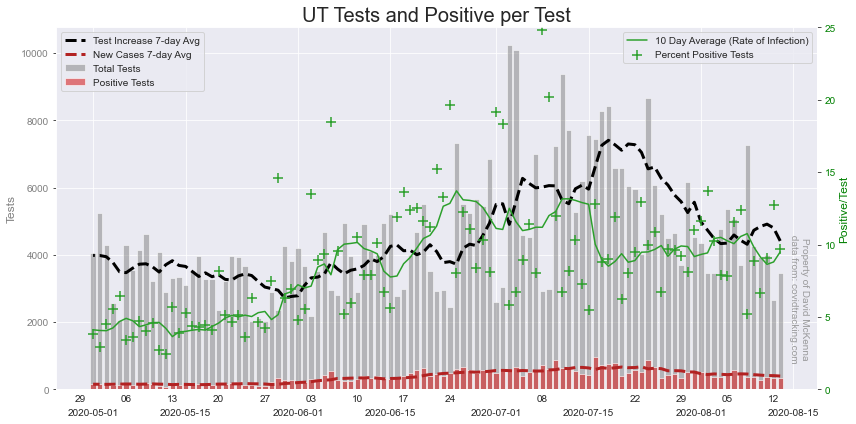

In [3]:
UT = State_Subset('UT',df)

Roll_Avg(UT,'totalTestResultsIncrease',[7])
Roll_Avg(UT,'positiveIncrease',[7])
Roll_Avg(UT,'PosPerTest',[7])
UT_1 = UT[UT['date'] >= '2020-05-01'] # select the data after the rampup of testing
#define start and end dates for x limits- thus we can average
#over all data but only plot the interesing part
start = UT_1[UT_1['date'] == '2020-04-15']['date']
end = UT_1.date.max() + pd.DateOffset(1)
Roll_Avg(UT,'PosPerTest', [10])


sns.set_style("dark")  # to remove grid lines because of the 2 y axis they overlap and are confusing                  
fig, ax1 = plt.subplots(figsize = (12,6))

plt.title('UT Tests and Positive per Test', fontdict={'fontsize':20})
date_ticks(ax1,UT)
watermark(fig,loc_x=0.94)

color = 'gray'

ax1.bar(UT_1['date'], UT_1['totalTestResultsIncrease'], 
        label='Total Tests',color='gray',alpha=0.5)
ax1.bar(UT_1['date'], UT_1['positiveIncrease'], 
        label='Positive Tests',color='tab:red',alpha=0.6)
ax1.plot(UT_1['date'],UT_1.roll_totalTestResultsIncrease_7, color='black',
         linestyle = '--', linewidth = 3,
         label = 'Test Increase 7-day Avg')
ax1.plot(UT_1['date'],UT_1.roll_positiveIncrease_7, color='firebrick',
         linestyle = '--', linewidth = 3,
         label = 'New Cases 7-day Avg')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
fig = plt.ylabel('Tests', fontdict={'fontsize':12},color=color)

ax2 = ax1.twinx() 

color = 'green'
fig = plt.scatter(UT_1['date'], UT_1['PosPerTest'],
                  marker='+',s=100,color='tab:green' ,label='Percent Positive Tests')
ax2 = plt.plot(UT_1['date'], UT_1.roll_PosPerTest_7, label='10 Day Average (Rate of Infection)', color='tab:green')
ax2 = plt.ylabel('Positive/Test', fontdict={'fontsize':12},color=color)
ax2 = plt.tick_params(axis='y', labelcolor=color)
ax2 = plt.ylim(0,25)
ax2 = plt.legend(loc='upper right')

fig = plt.tight_layout()

plt.savefig('UT_Test_+_Positive_Per_Test.png')
plt.show()



Today is Aug-13-2020 


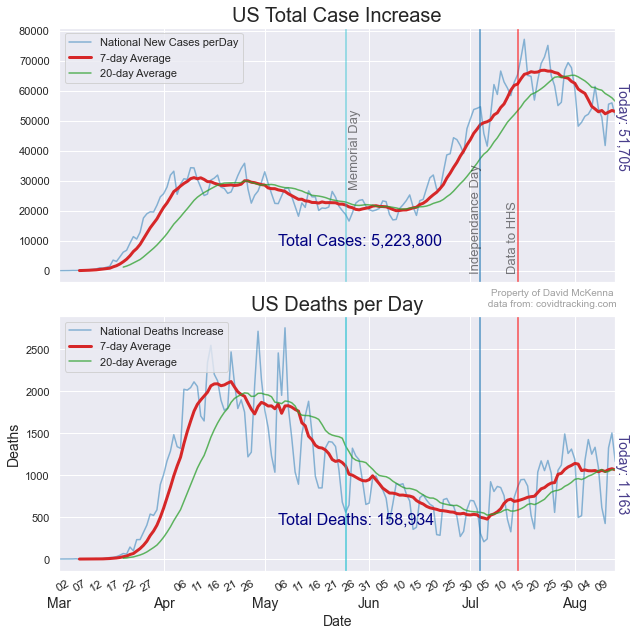

In [4]:
# Plot the national case increase with 20-day average
sns.set()

print('Today is ' + today.strftime("%b-%d-%Y ")) #To know if the latest data was updated
total_case = df['positiveIncrease'].sum()
total_death = df['deathIncrease'].sum()

# Define position of annotations
x_loc = df.date.max() - pd.DateOffset(100)
y_loc_c = df['positiveIncrease'].max()/ 1.75
y_loc_d = df['deathIncrease'].max()/ 2.3
# Extract the latest totals
value_today_case = df.groupby('date')['positiveIncrease'].sum().iloc[-1]
value_today_death = df.groupby('date')['deathIncrease'].sum().iloc[-1]

# Define the date format for x-tick labels    
months = mdates.MonthLocator()  # every month
mon_fmt = mdates.DateFormatter('%b') # Formatted as 'Mar' 
days = mdates.DayLocator(interval=5)  # Every 5 days
day_fmt = mdates.DateFormatter('%d')

fig, ax = plt.subplots(2,1,sharex=True,figsize = (9,9))

# round to nearest years.
datemin = np.datetime64(df['date'][0], 'm')
datemax = np.datetime64(df['date'].max(), 'm') + np.timedelta64(1, 'D')
# Define the x axis start and end dates 
end = df['date'].max()
start = df['date'].min()
# Annotate the copyright and data source 
fig.text(0.96,0.515, 'Property of David McKenna \n data from: covidtracking.com',
         fontsize=10, color='gray',
         ha='right', va='bottom', alpha=0.75)
# Plot National Case data on axis 0
df.groupby('date')['positiveIncrease'].sum().plot(ax=ax[0],label='National New Cases perDay',
                                                        color='tab:blue',alpha=0.5)
df.groupby('date')['positiveIncrease'].sum().rolling(7).mean().plot(ax=ax[0],label='7-day Average',
                                                                    color='tab:red',linewidth=3)
df.groupby('date')['positiveIncrease'].sum().rolling(20).mean().plot(ax=ax[0],label='20-day Average',
                                                                    color='tab:green',alpha=0.75)
# Annotate important dates
ax[0].axvline(x='2020-05-25',
              color='tab:cyan', linewidth=1.5, alpha=0.5)
ax[0].annotate('Memorial Day', ('2020-05-26'  ,28000),
               color='black',rotation=90,fontsize=13,alpha=0.5)
ax[0].axvline(x='2020-07-04',
              color='tab:blue', linewidth=1.5, alpha=0.75)
ax[0].annotate('Independance Day', ('2020-07-01'  ,0),
               color='black',rotation=90,fontsize=13,alpha=0.5)
ax[0].axvline(x='2020-07-15',
              color='red', linewidth=2, alpha=0.5)
ax[0].annotate('Data to HHS', ('2020-07-12'  ,0),
               color='black',rotation=90,fontsize=13,alpha=0.5)
# Add annotation of the sum of all US cases and Today's value
ax[0].annotate('Total Cases: {}'.format(place_value(total_case)),(x_loc,y_loc_c), fontsize = 16,color='navy')
ax[0].annotate('Today: {}'.format(place_value(value_today_case)),
               (end ,value_today_case/1.5),
                 rotation=270,color='darkslateblue',fontsize=14)
# Set Legend and Title
ax[0].legend(loc='upper left')
ax[0].set_title('US Total Case Increase', fontdict={'fontsize':20}) 


# Plot National Death data on axis 1
df.groupby('date')['deathIncrease'].sum().plot(ax=ax[1],label='National Deaths Increase',color='tab:blue',alpha=.5)
df.groupby('date')['deathIncrease'].sum().rolling(7).mean().plot(ax=ax[1],label='7-day Average',
                                                                color='tab:red',linewidth=3)
df.groupby('date')['deathIncrease'].sum().rolling(20).mean().plot(ax=ax[1],label='20-day Average',
                                                                  color='tab:green',alpha=0.75)
#format the ticks and labels
ax[1].xaxis.set_major_locator(months)
ax[1].xaxis.set_major_formatter(mon_fmt)
ax[1].xaxis.set_minor_locator(days)
ax[1].xaxis.set_minor_formatter(day_fmt)
ax[1].set_xlim([start,end])
plt.setp(ax[1].xaxis.get_minorticklabels(), rotation=30, size=12)
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=0, size=14)
ax[1].xaxis.set_tick_params(pad=20)
ax[1].grid(True)

# Create vertical lines at important dates
ax[1].axvline(x='2020-05-25', color='tab:cyan', linewidth=1.5, alpha=0.75)
ax[1].axvline(x='2020-07-04', color='tab:blue', linewidth=1.5, alpha=0.75)
ax[1].axvline(x='2020-07-15',
              color='red', linewidth=2, alpha=0.5)
# Add annotation of the sum of all US Deaths and Today's value
ax[1].annotate('Total Deaths: {}'.format(place_value(total_death)),(x_loc,y_loc_d), fontsize = 16,color='navy')
ax[1].annotate('Today: {}'.format(place_value(value_today_death)),
               (end ,value_today_death/2),
                 rotation=270,color='darkslateblue',fontsize=14)
# Set Legend, Title, axis labels
ax[1].legend(loc='upper left')
ax[1].set_title('US Deaths per Day', fontdict={'fontsize':20}) 
ax[1].set_ylabel('Deaths', fontdict={'fontsize':14})
ax[1].set_xlabel('Date', fontdict={'fontsize':14})

#Plot and save figure
fig = plt.tight_layout()
plt.savefig('national.png')
plt.show()

Today is Aug-13-2020 


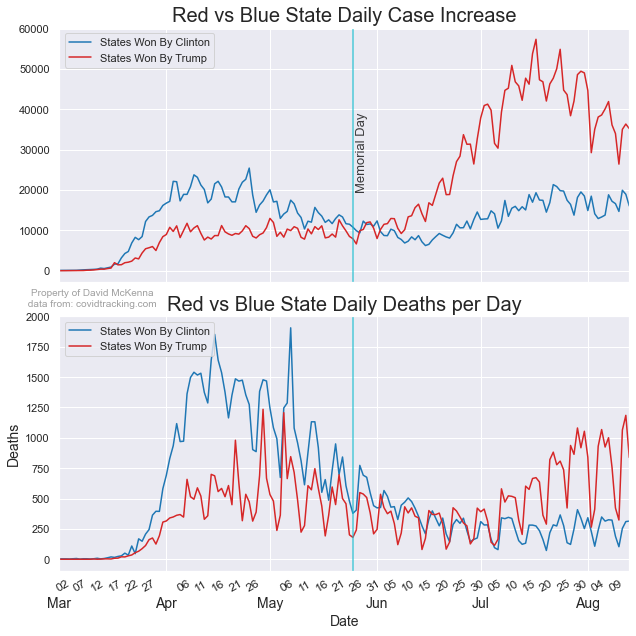

In [5]:
# Plot the "red states" vs "blue states" Case/Death increase
from My_Functions import *

df_election = States_Won(df)

print('Today is ' + today.strftime("%b-%d-%Y ")) #To know if the latest data was updated

# Define the date format for x-tick labels    
months = mdates.MonthLocator()  # every month
mon_fmt = mdates.DateFormatter('%b') # Formatted as 'Mar' 
days = mdates.DayLocator(interval=5)  # Every 5 days
day_fmt = mdates.DateFormatter('%d')

fig, ax = plt.subplots(2,1,sharex=True,figsize = (9,9))

# round to nearest years.
datemin = np.datetime64(df_election['date'][0], 'm')
datemax = np.datetime64(df_election['date'].max(), 'm') + np.timedelta64(1, 'D')
# Define the x axis start and end dates 
end = df_election['date'].max()
start = df_election['date'].min()
# Annotate the copyright and data source 
fig.text(0.25,0.515, 'Property of David McKenna \n data from: covidtracking.com',
         fontsize=10, color='gray',
         ha='right', va='bottom', alpha=0.75)

# Plot National R/B Case data on axis 0
df_election.groupby(['date','2016 Won By'])['positiveIncrease'].sum().unstack().plot(ax=ax[0],label=['Clinton','Trump'],
                                                        color=['tab:blue','tab:red'])
# Annotate important dates
ax[0].axvline(x='2020-05-25',
              color='tab:cyan', linewidth=1.5, alpha=0.75)
ax[0].annotate('Memorial Day', ('2020-05-26'  ,20000),
               color='black',rotation=90,fontsize=13,alpha=0.75)

# Set Legend and Title
ax[0].legend(loc='upper left')
ax[0].set_title('Red vs Blue State Daily Case Increase', fontdict={'fontsize':20}) 


# Plot R/B Death data on axis 1
df_election.groupby(['date','2016 Won By'])['deathIncrease'].sum().unstack().plot(ax=ax[1],
                                                    color=['tab:blue','tab:red'])
#format the ticks and labels
ax[1].xaxis.set_major_locator(months)
ax[1].xaxis.set_major_formatter(mon_fmt)
ax[1].xaxis.set_minor_locator(days)
ax[1].xaxis.set_minor_formatter(day_fmt)
ax[1].set_xlim([start,end])
plt.setp(ax[1].xaxis.get_minorticklabels(), rotation=30, size=12)
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=0, size=14)
ax[1].xaxis.set_tick_params(pad=20)
ax[1].grid(True)

# Create vertical lines at important dates
ax[1].axvline(x='2020-05-25', color='tab:cyan', linewidth=1.5, alpha=0.75)

# Set Legend, Title, axis labels
ax[1].legend(loc='upper left')
ax[1].set_title('Red vs Blue State Daily Deaths per Day', fontdict={'fontsize':20}) 
ax[1].set_ylabel('Deaths', fontdict={'fontsize':14})
ax[1].set_xlabel('Date', fontdict={'fontsize':14})

#Plot and save figure
fig = plt.tight_layout()
plt.savefig('R_B_National.png')
plt.show()

In [6]:
df_election = Merge_Pop(df_election)

df_election['positiveIncreasescale'] = df_election['positiveIncrease']/(df_election['Population']/1000000)
df_election['deathIncreasescale'] = df_election['deathIncrease']/(df_election['Population']/1000000)


Today is Aug-13-2020 


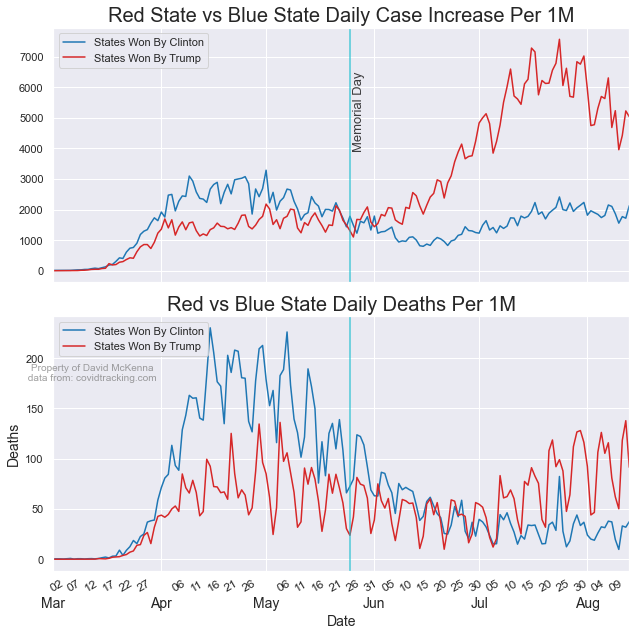

In [7]:
# Plot the "red states" vs "blue states" Case/Death increase


print('Today is ' + today.strftime("%b-%d-%Y ")) #To know if the latest data was updated

# Define the date format for x-tick labels    
months = mdates.MonthLocator()  # every month
mon_fmt = mdates.DateFormatter('%b') # Formatted as 'Mar' 
days = mdates.DayLocator(interval=5)  # Every 5 days
day_fmt = mdates.DateFormatter('%d')

fig, ax = plt.subplots(2,1,sharex=True,figsize = (9,9))

# round to nearest years.
datemin = np.datetime64(df_election['date'][0], 'm')
datemax = np.datetime64(df_election['date'].max(), 'm') + np.timedelta64(1, 'D')
# Define the x axis start and end dates 
end = df_election['date'].max()
start = df_election['date'].min()
# Annotate the copyright and data source 
fig.text(0.25,0.4, 'Property of David McKenna \n data from: covidtracking.com',
         fontsize=10, color='gray',
         ha='right', va='bottom', alpha=0.75)

# Plot National R/B Case data on axis 0
df_election.groupby(['date','2016 Won By'])['positiveIncreasescale'].sum().unstack().plot(ax=ax[0],label=['Clinton','Trump'],
                                                        color=['tab:blue','tab:red'])
# Annotate important dates
ax[0].axvline(x='2020-05-25',
              color='tab:cyan', linewidth=1.5, alpha=0.75)
ax[0].annotate('Memorial Day', ('2020-05-26'  ,4000),
               color='black',rotation=90,fontsize=13,alpha=0.75)

# Set Legend and Title
ax[0].legend(loc='upper left')
ax[0].set_title('Red State vs Blue State Daily Case Increase Per 1M', fontdict={'fontsize':20}) 


# Plot R/B Death data on axis 1
df_election.groupby(['date','2016 Won By'])['deathIncreasescale'].sum().unstack().plot(ax=ax[1],
                                                    color=['tab:blue','tab:red'])
#format the ticks and labels
ax[1].xaxis.set_major_locator(months)
ax[1].xaxis.set_major_formatter(mon_fmt)
ax[1].xaxis.set_minor_locator(days)
ax[1].xaxis.set_minor_formatter(day_fmt)
ax[1].set_xlim([start,end])
plt.setp(ax[1].xaxis.get_minorticklabels(), rotation=30, size=12)
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=0, size=14)
ax[1].xaxis.set_tick_params(pad=20)
ax[1].grid(True)

# Create vertical lines at important dates
ax[1].axvline(x='2020-05-25', color='tab:cyan', linewidth=1.5, alpha=0.75)

# Set Legend, Title, axis labels
ax[1].legend(loc='upper left')
ax[1].set_title('Red vs Blue State Daily Deaths Per 1M', fontdict={'fontsize':20}) 
ax[1].set_ylabel('Deaths', fontdict={'fontsize':14})
ax[1].set_xlabel('Date', fontdict={'fontsize':14})

#Plot and save figure
fig = plt.tight_layout()
plt.savefig('R_B_National_per1M.png')
plt.show()



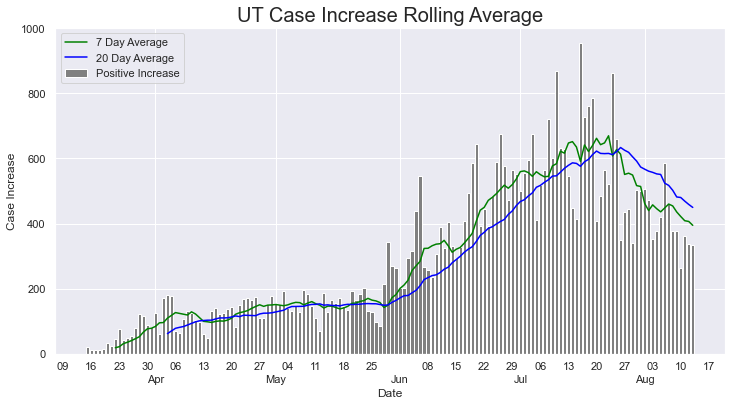

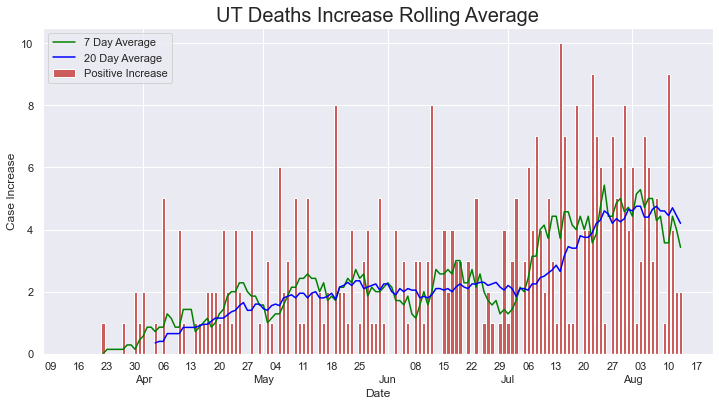

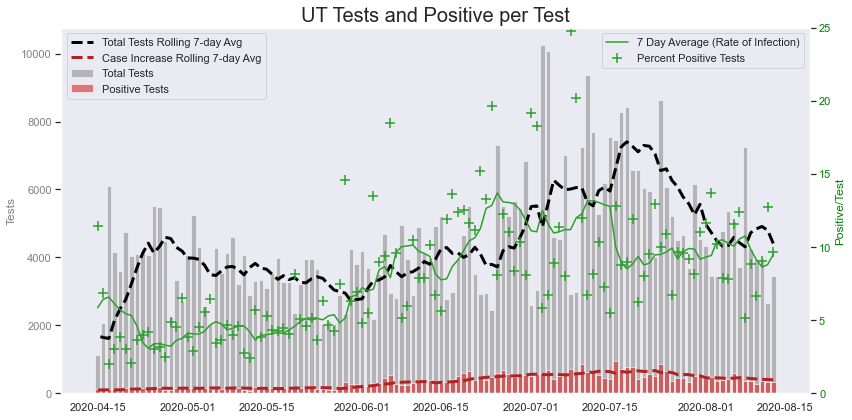

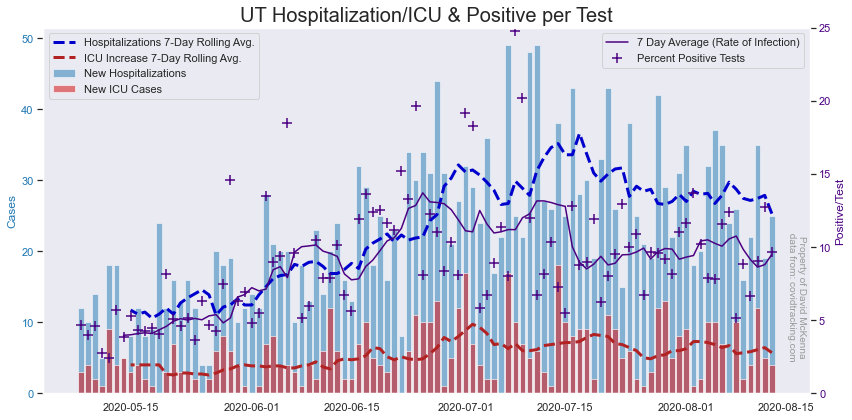

In [8]:
Basic_Analysis_Roll(df,'UT')

